Create variables for the paths to the datasets

In [1]:
import os

base_dir = 'dataset'
training_dir = os.path.join(base_dir, 'Train_Alphabet')
test_dir = os.path.join(base_dir, 'Test_Alphabet')

print(os.listdir(training_dir))
print(len(os.listdir(training_dir)))

['Y', 'S', 'V', 'U', 'Q', 'W', 'T', 'Blank', 'R', 'H', 'I', 'N', 'F', 'P', 'M', 'X', 'A', 'D', 'E', 'J', 'K', 'Z', 'B', 'G', 'O', 'C', 'L']
27


Creating the model
-> Assuming images are in uniform size of 200 x 200 pixels
-> Softmax activation used in multiclass identification

In [72]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
import scipy
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [79]:
def create_model():
    model = tf.keras.models.Sequential([
        #data_augmentation,
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(27, activation='softmax')
    ])
    #RMSprop(learning_rate=1e-3)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model

**Attempt to Create New Model using pretrained models

In [58]:
data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.RandomFlip(mode="horizontal", input_shape=(200,200, 3)),
    tf.keras.layers.RandomTranslation(height_factor=0, width_factor=0.1),
    tf.keras.layers.RandomRotation((20./360)),
    tf.keras.layers.RandomZoom((0, -0.2), (0, -0.2))
])

In [69]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(200, 200, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input


inputs = tf.keras.Input(shape=(200,200,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
outputs = tf.keras.layers.Dense(27, activation='softmax')(x)
pretrained_model = tf.keras.Model(inputs, outputs)

pretrained_model.compile(optimizer=RMSprop(learning_rate=1e-3),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

Will create training generators:

In [84]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#'''
train_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                  rotation_range=20, #Rotation Range is in Degrees not Radians
                                  #zoom_range=[-0.2, 0],
                                  #horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  )
#'''                                 
#train_datagen = ImageDataGenerator(rescale = 1.0 / 255.)
test_datagen = ImageDataGenerator(rescale = 1.0 / 255. )
'''
test_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                  rotation_range=20, #Rotation Range is in Degrees not Radians
                                  zoom_range=[-0.2, 0],
                                  #horizontal_flip=True,
                                  width_shift_range=0.1,
                                  #height_shift_range=0.1,
                                  )
#'''  
#Create the generator that creates batches of 20
batchSize = 20
train_generator = train_datagen.flow_from_directory(training_dir,
                                                   batch_size=batchSize,
                                                   class_mode='categorical',
                                                   #color_mode='grayscale',
                                                   target_size=(200,200))
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=batchSize,
                                                 class_mode='categorical',
                                                 #color_mode='grayscale',
                                                 target_size=(200,200))



Found 24300 images belonging to 27 classes.
Found 2700 images belonging to 27 classes.


Preview a random subset of images

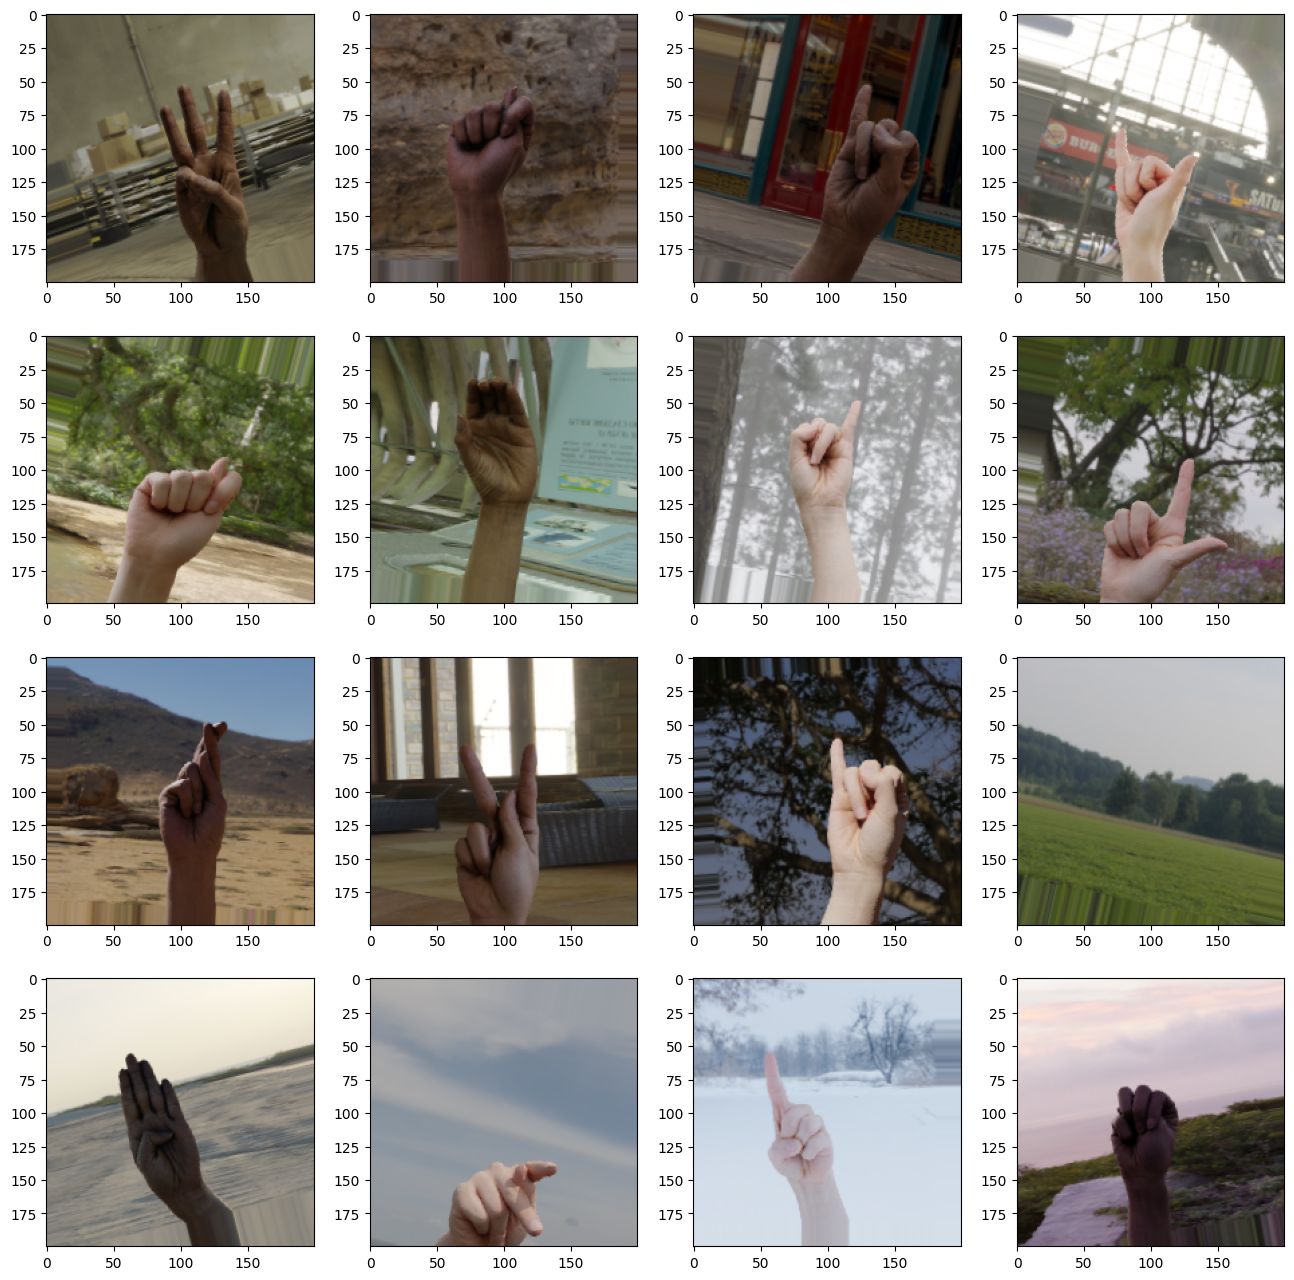

In [90]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#Change this letter to view different pictures of letters
letter = 'A'
letter_dir = os.path.join(training_dir, letter)
letter_file_names = os.listdir(letter_dir)


nrows = 4
ncols = 4
num_pics = int((nrows * ncols))

pic_index = 20

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += num_pics

photos = [os.path.join(letter_dir, file_name) for file_name in letter_file_names[pic_index - num_pics:pic_index]]

#EDIT this, use 
for i, img_path in enumerate(photos):
    #Create Subplot, indexed at 1
    subplot = plt.subplot(nrows, ncols, i+1)
    #subplot.axis('Off')
    #image = mpimg.imread(img_path)
    #img_tensor = tf.keras.preprocessing.image.img_to_array(image)
    image, label = train_generator.next()
    plt.imshow(image[0])
    
plt.show()



Create training process


In [88]:
EPOCHS = 20
model = create_model()
#model = pretrained_model
history = model.fit(
    train_generator,
    steps_per_epoch=100, #2000 images = batch_size * steps
    epochs=EPOCHS,
    validation_data=test_generator,
    validation_steps=50, #1000 images = batch_size * steps
    verbose=1
)

Epoch 1/20
100/100 [==============================] - 33s 325ms/step - loss: 3.3086 - accuracy: 0.0355 - val_loss: 3.2957 - val_accuracy: 0.0390
Epoch 2/20
100/100 [==============================] - 32s 320ms/step - loss: 3.2985 - accuracy: 0.0345 - val_loss: 3.2956 - val_accuracy: 0.0360
Epoch 3/20
100/100 [==============================] - 32s 321ms/step - loss: 3.2975 - accuracy: 0.0405 - val_loss: 3.2904 - val_accuracy: 0.0440
Epoch 4/20
100/100 [==============================] - 33s 326ms/step - loss: 3.2941 - accuracy: 0.0395 - val_loss: 3.2480 - val_accuracy: 0.0470
Epoch 5/20
100/100 [==============================] - 33s 325ms/step - loss: 3.1470 - accuracy: 0.0740 - val_loss: 2.8070 - val_accuracy: 0.1510
Epoch 6/20
100/100 [==============================] - 32s 320ms/step - loss: 2.8876 - accuracy: 0.1345 - val_loss: 2.2867 - val_accuracy: 0.3350
Epoch 7/20
100/100 [==============================] - 32s 319ms/step - loss: 2.3918 - accuracy: 0.2460 - val_loss: 1.7476 - val_ac

**Visualizing Intermediate Representations:

*** Allows us to understand how the model breaks the image down and processes the information


In [66]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 99, 99, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 97, 97, 32)        4640      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 48, 48, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 46, 46, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 23, 23, 64)     

1/1 [==============================] - 0s 65ms/step


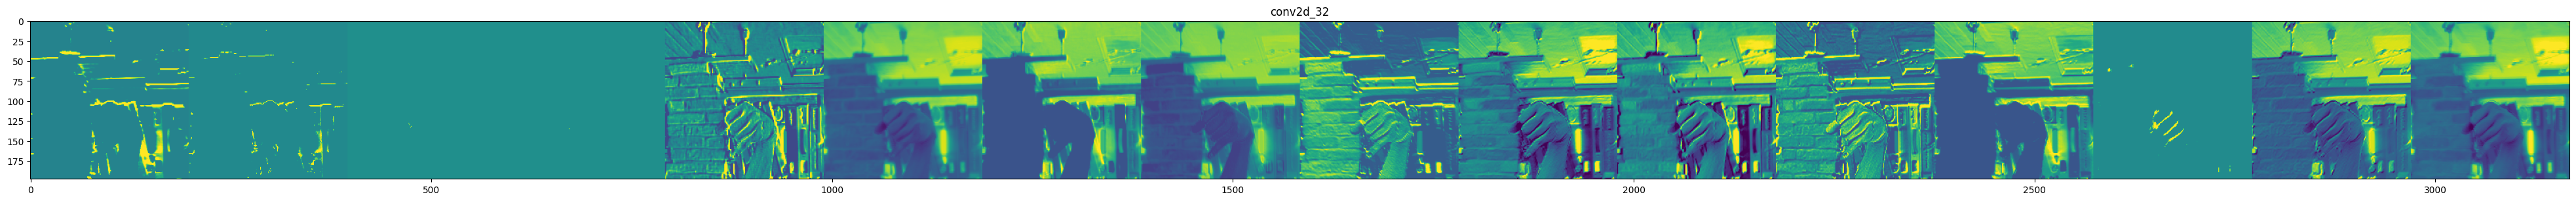

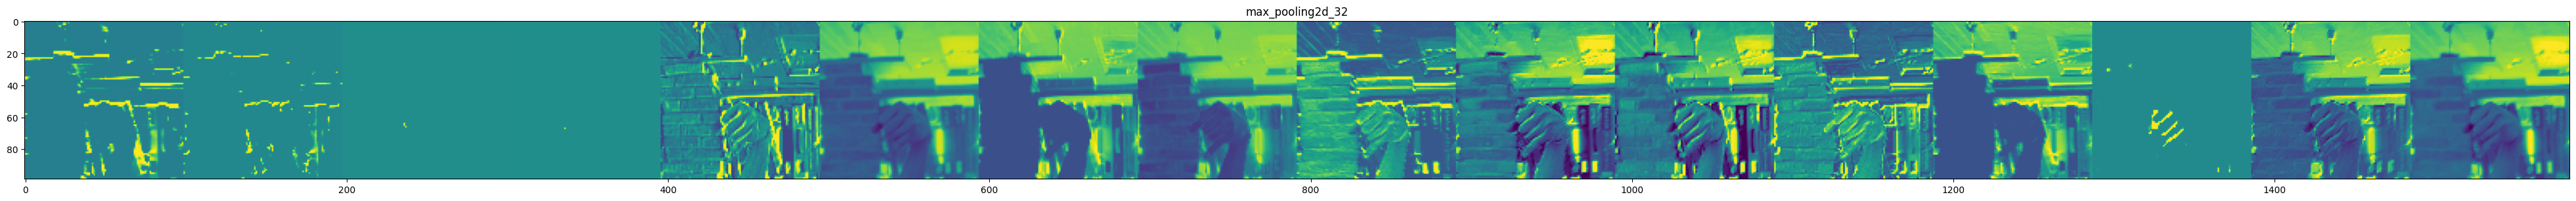

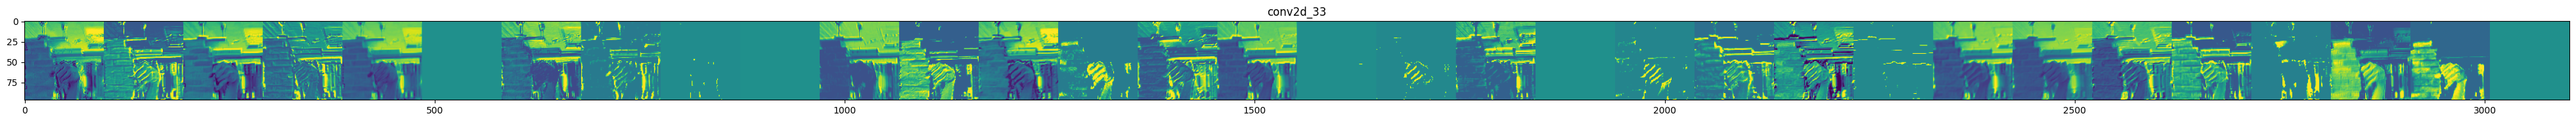

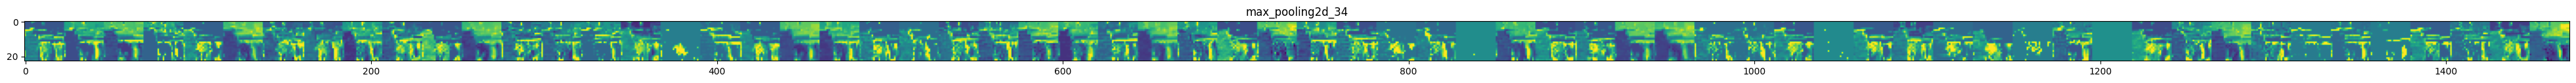

In [68]:
import numpy as np
import random
import math
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#Change this letter to view different pictures of letters
letter = 'J'
letter_dir = os.path.join(training_dir, letter)
letter_file_names = os.listdir(letter_dir)
photos = [os.path.join(letter_dir, filename) for filename in letter_file_names]

img_path = random.choice(photos)
img = load_img(img_path, target_size=(200, 200)) #PIL image
x = img_to_array(img) #Numpy array with shape (200, 200 3)
x = x.reshape((1,) + x.shape) #Reshape with (1, 150, 150, 3)
x /= 255.0

layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) #Takes model input, returns output of all layers

activations = activation_model.predict(x)

#images_per_row = 16
layer_names = [layer.name for layer in model.layers]
for layer_name, layer_activation in zip(layer_names, activations):
    if len(layer_activation.shape) != 4:
        continue
    
    n_features = layer_activation.shape[-1] #Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features)
    #n_cols = n_features // images_per_row 
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
        channel_image = layer_activation[0, :, :, i]
        channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
        if (channel_image.std() != 0):
            channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128 
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[:, (i * size) : ((i+1) * size)] = channel_image
    scale = 50. / n_features
    plt.figure( figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')


**Plotting history about the training process

Text(0.5, 1.0, 'Training and validation loss')

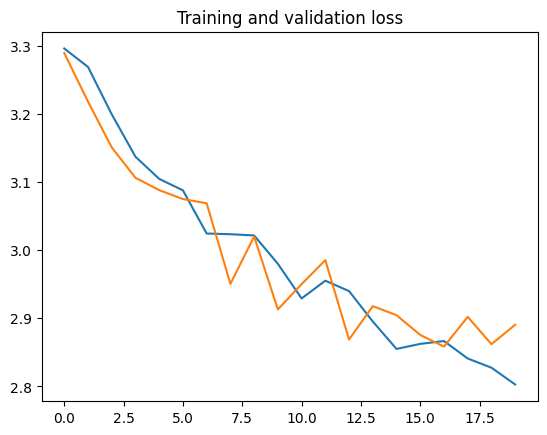

In [14]:

acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

# Plot training and validation accuracy per epoch
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

# Plot training and validation loss per epoch
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )